# Задание
Для выполнения домашнего задания необходимо взять файл boston house-prices datase (sklearn.datasets.load_boston) и построить модель.
По аналогии задания к лекции «Классификация: Логистическая регрессия и SVM».
А именно построить модель регрессии, дерево решений, оптимизировать параметры и сравнить результаты.

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Функции для исследования

In [ ]:
# Для поиска выбросов будем использовать boxplot, pairplot
def get_boxplot(X, columns=None):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.boxplot(x=X[i])
    plt.show()
  pass  

def get_pairplot(X, columns=None):
  if columns is None:
    columns = X.columns

  sns.pairplot(X[columns])
  pass

def get_hist(X, columns=None, bins='auto'):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.histplot(x=X[i], bins=bins)
    plt.grid()
    plt.show()
  pass

def get_heatmap(X, columns=None, target=None, thres=0.5):
  if columns is None:
    columns = X.columns

  # если задана целевая переменная - вывести только те переменные
  # из columns, у которых корреляция с целевой выше порога 
  if target is not None:
    columns = X[columns].corr().index[abs(X[columns].corr()[target]) > thres]
 
  sns.heatmap(X[columns].corr(), cmap='coolwarm', annot = True, )
  pass

# Решение

## Работа с датасетом

Воспользуемся результатами обработки датасета, выполненными в предыдущем домашнем задании:

In [ ]:
from sklearn.datasets import load_boston
data = pd.read_csv(load_boston()['filename'], skiprows=1)

In [ ]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Убираем выбросы

In [ ]:
data = data[data['MEDV'] < 50.0]
data.shape

(490, 14)

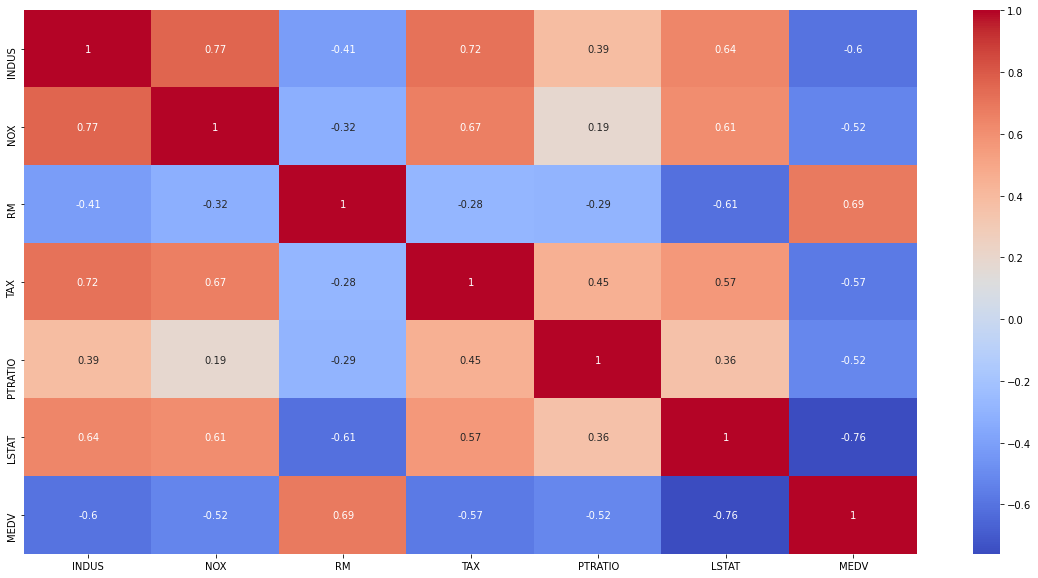

In [ ]:
plt.figure(figsize=(20, 10))
get_heatmap(data, target='MEDV')

оставляем только переменные, у которых корреляция с целевой переменной выше 0.5:

In [ ]:
data = data[['LSTAT', 'RM', 'INDUS', 'TAX', 'NOX', 'PTRATIO', 'MEDV']]

Добавим в наш датасет две новых переменных:
- произведение RM * LSTAT
- отношение RM / LSTAT

и уберем исходные переменные RM, LSTAT:

In [ ]:
data['mult'] = data['RM'] * data['LSTAT']
data['divide'] = data['RM'] / data['LSTAT']
data.drop(['RM','LSTAT'], axis = 1, inplace=True)

## Модель регрессии

Разобьем на обучающую и тестовую выборку, сделаем нормирование и расчитаем точность регрессии

In [ ]:
y = data['MEDV']
X = data.drop('MEDV', axis=1)

! В параметрах метода train_test_split стоит shuffle=True, что означает случайное перемешивание, и значит, в случае повторного запуска расчета все числовые параметры, которые я ниже описываю - будут другими.

In [ ]:
# разбиваем данные на train и на test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.3)  

In [ ]:
# делаем нормирование
from sklearn.preprocessing import StandardScaler
stX = StandardScaler()
X_train.loc[:,:] = stX.fit_transform(X_train)
X_test.loc[:,:] = stX.transform(X_test)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((343, 6), (343,), (147, 6), (147,))

Первая модель - Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print(f'Точность на обучающей выборке: {model1.score(X_train, y_train):.5f}')
print(f'Точность на тестовой выборке: {model1.score(X_test, y_test):.5f}')

Точность на обучающей выборке: 0.74925
Точность на тестовой выборке: 0.74900


Вторая модель - Метод опорных векторов

In [ ]:
from sklearn.svm import SVR
model2 = SVR()
model2.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
print(f'Точность на обучающей выборке: {model2.score(X_train, y_train):.5f}')
print(f'Точность на тестовой выборке: {model2.score(X_test, y_test):.5f}')

Точность на обучающей выборке: 0.73226
Точность на тестовой выборке: 0.69632


Третья модель - Дерево решений

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model3 = DecisionTreeRegressor()
model3.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
print(f'Точность на обучающей выборке: {model3.score(X_train, y_train):.5f}')
print(f'Точность на тестовой выборке: {model3.score(X_test, y_test):.5f}')

Точность на обучающей выборке: 1.00000
Точность на тестовой выборке: 0.67194


Вывод:

наилучшую точность показала линейная регрессия, Дерево же вообще переобучилось и показало низкую точность на тестовой выборке.

## Оптимизация параметров

In [ ]:
from sklearn.model_selection import GridSearchCV

### Оптимизируем параметры Линейной регрессии - путем перебора параметров:

In [ ]:
model1 = LinearRegression()

parameters = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]
              }

grid = GridSearchCV(model1, parameters, cv=5, scoring='r2').fit(X_train, y_train)
grid.best_score_

0.7300563808276733

In [ ]:
grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

Обучим линейную модель на этих лучших параметрах:

In [ ]:
model1 = LinearRegression({'copy_X': True, 'fit_intercept': True, 'normalize': True})
model1.fit(X_train, y_train)
print(f'Точность на обучающей выборке: {model1.score(X_train, y_train):.5f}')
print(f'Точность на тестовой выборке: {model1.score(X_test, y_test):.5f}')

Точность на обучающей выборке: 0.74925
Точность на тестовой выборке: 0.74900


### Оптимизируем параметры Метода опорных векторов

In [ ]:
model2 = SVR()

parameters = {'kernel':['linear','poly', 'rbf', 'sigmoid'],
              'degree':[2,3],
              'gamma': ['scale', 'auto'],
              'shrinking': [True, False],
              'epsilon': [0.01, 0.1, 0.2]
              }

grid = GridSearchCV(model2, parameters, cv=5).fit(X_train, y_train)
grid.best_score_

0.7228430119600878

In [ ]:
grid.best_params_

{'degree': 2,
 'epsilon': 0.01,
 'gamma': 'scale',
 'kernel': 'linear',
 'shrinking': True}

Заметим, что лучшая модель в переборе имеет линейное ядро, в отличие от по умолчанию 'rbf', с которым строилась модель регрессии опорными векторами выше.

In [ ]:
model2 = grid.best_estimator_

Обучим модель на этих лучших параметрах:

In [ ]:
model2.fit(X_train, y_train)
print(f'Точность на обучающей выборке: {model2.score(X_train, y_train):.5f}')
print(f'Точность на тестовой выборке: {model2.score(X_test, y_test):.5f}')

Точность на обучающей выборке: 0.73901
Точность на тестовой выборке: 0.72098


### Оптимизируем параметры Дерева решений:

In [ ]:
model3 = DecisionTreeRegressor(random_state=42 )

parameters = {'criterion': ["mse", "friedman_mse", "mae"],
              'splitter': ["best", "random"], 
              'max_depth': [2, 3, 4, 5, 9, 13, 15], 
              'min_samples_split': [2, 3, 5, 7, 10, 15, 25],
              'min_samples_leaf': [1, 2, 3, 5, 7, 10, 15],
              'max_features': [1, 2, 3, 4]
              }

grid = GridSearchCV(model3, parameters, cv=5, scoring='r2').fit(X_train, y_train)
grid.best_score_

0.7510561425432103

In [ ]:
grid.best_params_

{'criterion': 'mae',
 'max_depth': 9,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'splitter': 'best'}

In [ ]:
model3 = grid.best_estimator_

In [ ]:
#model3 = DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=15,
#                      max_features=None, max_leaf_nodes=None,
#                      min_impurity_decrease=0.0, min_impurity_split=None,
#                      min_samples_leaf=2, min_samples_split=15,
#                      min_weight_fraction_leaf=0.0, presort='deprecated',
#                      random_state=None, splitter='random')

model3.fit(X_train, y_train)
print(f'Точность на обучающей выборке: {model3.score(X_train, y_train):.5f}')
print(f'Точность на тестовой выборке: {model3.score(X_test, y_test):.5f}')

Точность на обучающей выборке: 0.87453
Точность на тестовой выборке: 0.77992


# Выводы

Линейная регрессия:
- Точность на тестовой выборке: 0.74900
- После подбора: 0.74900

Метод опорных векторов:
- Точность на тестовой выборке: 0.69632
- После подбора: 0.72098

Дерево решений
- Точность на тестовой выборке: 0.67194
- После подбора: 0.77992

Как видно, все алгоритмы улучшили свою точность на тестовой выборке после подбора лучшего сочетания параметров с помощью GridSearch.
При этом, сильнее всего улучшилась модель Дерева решений, в итоге показавшая лучший результат, хотя первоначально, при параметрах по умолчанию показывал напротив - самый низкий.
Это показывает как важность подбора параметров, так и - пожалуй - неустойчивость и высокую чувствительность этой модели от входящих параметров.

